In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils 
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [2]:
# Paths for data.
Ravdess = '../RAVDESS_Speech/'
# Crema = "../AudioWAV/"
Tess = "../TESS/"
Savee = "../SAVEE/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-01-01-0...
1,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-01-02-0...
2,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-02-01-0...
3,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-02-02-0...
4,calm,../RAVDESS_Speech/Actor_01/03-01-02-01-01-01-0...


In [4]:
# crema_directory_list = os.listdir(Crema)

# file_emotion = []
# file_path = []

# for file in crema_directory_list:
#     # storing file paths
#     file_path.append(Crema + file)
#     # storing file emotions
#     part=file.split('_')
#     if part[2] == 'SAD':
#         file_emotion.append('sad')
#     elif part[2] == 'ANG':
#         file_emotion.append('angry')
#     elif part[2] == 'DIS':
#         file_emotion.append('disgust')
#     elif part[2] == 'FEA':
#         file_emotion.append('fear')
#     elif part[2] == 'HAP':
#         file_emotion.append('happy')
#     elif part[2] == 'NEU':
#         file_emotion.append('neutral')
#     else:
#         file_emotion.append('Unknown')
        
# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Crema_df = pd.concat([emotion_df, path_df], axis=1)
# Crema_df.head()

In [5]:
tess_directory_list = os.listdir(Tess)

# file_emotion = []
# file_path = []

# for dir in tess_directory_list:
#     directories = os.listdir(Tess + dir)
#     for file in directories:
#         part = file.split('.')[0]
#         part = part.split('_')[2]
#         if part=='ps':
#             file_emotion.append('surprise')
#         else:
#             file_emotion.append(part)
#         file_path.append(Tess + dir + '/' + file)
        
# # dataframe for emotion of files
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Tess_df = pd.concat([emotion_df, path_df], axis=1)
# Tess_df.head()

path = []
emotion = []

for i in tess_directory_list:
    fname = os.listdir(Tess + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(Tess + i + "/" + f)
# emotion_df = pd.DataFrame(emotion, columns=['Emotions'])

# # dataframe for path of files.
# path_df = pd.DataFrame(path, columns=['Path'])
# TESS_df = pd.concat([emotion, path], axis=1)
# TESS_df.head()

TESS_df = pd.DataFrame(emotion, columns = ['Emotions'])

TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['Path'])],axis=1)
# TESS_df.labels.value_counts()
TESS_df.head()


,Emotions,Path
0,angry,../TESS/OAF_angry/OAF_back_angry.wav
1,angry,../TESS/OAF_angry/OAF_bar_angry.wav
2,angry,../TESS/OAF_angry/OAF_base_angry.wav
3,angry,../TESS/OAF_angry/OAF_bath_angry.wav
4,angry,../TESS/OAF_angry/OAF_bean_angry.wav


In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,../SAVEE/DC_a01.wav
1,angry,../SAVEE/DC_a02.wav
2,angry,../SAVEE/DC_a03.wav
3,angry,../SAVEE/DC_a04.wav
4,angry,../SAVEE/DC_a05.wav


In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df,Savee_df,TESS_df], axis = 0)
data_path.to_csv("data_path_ravdess.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-01-01-0...
1,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-01-02-0...
2,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-02-01-0...
3,neutral,../RAVDESS_Speech/Actor_01/03-01-01-01-02-02-0...
4,calm,../RAVDESS_Speech/Actor_01/03-01-02-01-01-01-0...


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

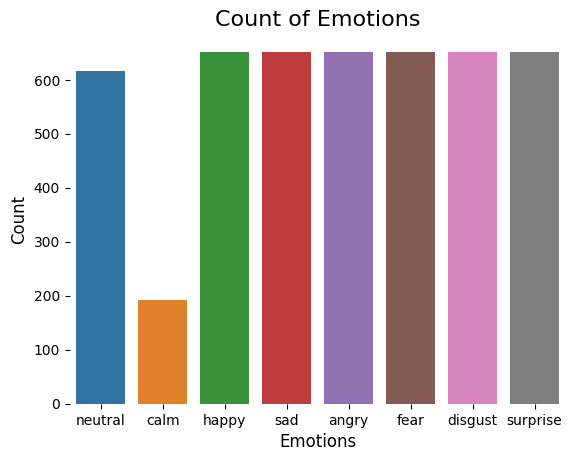

In [8]:
sns.countplot(x='Emotions', data = data_path)

plt.title('Count of Emotions', size=16)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

In [10]:
def extract_features(data):
    # ZCR
    result = np.array([])
    # zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    # result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
   

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally


    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [11]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [12]:
len(X), len(Y), data_path.Path.shape

(14160, 14160, (4720,))

In [13]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,labels
0,-647.205017,74.494820,-1.027089,18.256382,8.400715,2.474266,-6.123550,-2.492467,-16.309069,-2.110273,...,4.312694e-06,3.293364e-06,2.149553e-06,2.260914e-06,4.562520e-06,4.985617e-06,1.324619e-06,1.469305e-07,3.053402e-09,neutral
1,-488.228657,39.983277,6.905240,11.345090,6.206152,-0.849868,-4.559224,-7.244368,-10.339054,-5.947432,...,1.802768e-05,1.738093e-05,1.684707e-05,1.683875e-05,1.995415e-05,2.034259e-05,1.664207e-05,1.474130e-05,1.444326e-05,neutral
2,-714.374512,73.627441,-3.383080,19.450293,5.375023,1.764676,-8.947500,-3.630324,-18.455372,2.115432,...,8.582505e-07,9.570447e-07,7.741540e-07,5.212421e-07,3.252106e-07,4.883136e-07,2.353670e-07,2.240905e-08,9.753157e-11,neutral
3,-636.119141,74.385246,-5.053098,22.253006,8.646654,0.856430,-4.796639,-5.969506,-18.153780,-0.742294,...,6.987414e-06,7.038922e-06,6.659573e-06,6.937638e-06,1.117492e-05,5.767251e-06,2.024577e-06,1.944936e-07,2.701240e-09,neutral
4,-423.744368,26.140077,9.000116,9.465792,4.862262,-0.506501,-2.988153,-6.604313,-8.949060,-5.336207,...,9.943081e-05,1.000962e-04,1.086402e-04,9.702987e-05,1.052377e-04,9.827651e-05,9.833260e-05,1.002905e-04,9.357422e-05,neutral


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [14]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [15]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 148), (10620, 8), (3540, 148), (3540, 8))

In [17]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 148), (10620, 8), (3540, 148), (3540, 8))

In [18]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10620, 148, 1), (10620, 8), (3540, 148, 1), (3540, 8))

## Modelling

In [19]:
# model=Sequential()
# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Flatten())
# model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(0.3))

# model.add(Dense(units=8, activation='softmax'))
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# model.summary()


model = Sequential()

model.add(Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.5))

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=8, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 512)          4096      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 74, 512)           1835520   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 512)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 256)           655616    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 256)          0

In [20]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

# rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001)
# history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/50
664/664 [==============================] - 65s 96ms/step - loss: 1.8131 - accuracy: 0.2732 - val_loss: 1.5147 - val_accuracy: 0.4441 - lr: 0.0010
Epoch 2/50
664/664 [==============================] - 62s 93ms/step - loss: 1.4236 - accuracy: 0.4673 - val_loss: 1.1119 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 3/50
664/664 [==============================] - 62s 93ms/step - loss: 1.2390 - accuracy: 0.5480 - val_loss: 1.0414 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 4/50
664/664 [==============================] - 62s 93ms/step - loss: 1.1130 - accuracy: 0.5877 - val_loss: 0.9857 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 5/50
664/664 [==============================] - 62s 93ms/step - loss: 1.0073 - accuracy: 0.6234 - val_loss: 0.8559 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 6/50
664/664 [==============================] - 62s 94ms/step - loss: 0.9246 - accuracy: 0.6600 - val_loss: 0.8378 - val_accuracy: 0.6929 - lr: 0.0010
Epoch 7/50
664/664 [==============================] - 63s 

In [21]:
model.save('model.h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
filepath = 'model.h5'
keras.models.load_model(filepath)
model.evaluate(x_test,y_test)

111/111 [==============================] - 3s 31ms/step - loss: 0.7206 - accuracy: 0.8441


[0.7205849289894104, 0.8440678119659424]

111/111 [==============================] - 3s 31ms/step - loss: 0.7206 - accuracy: 0.8441
Accuracy of our model on test data :  84.40678119659424 %


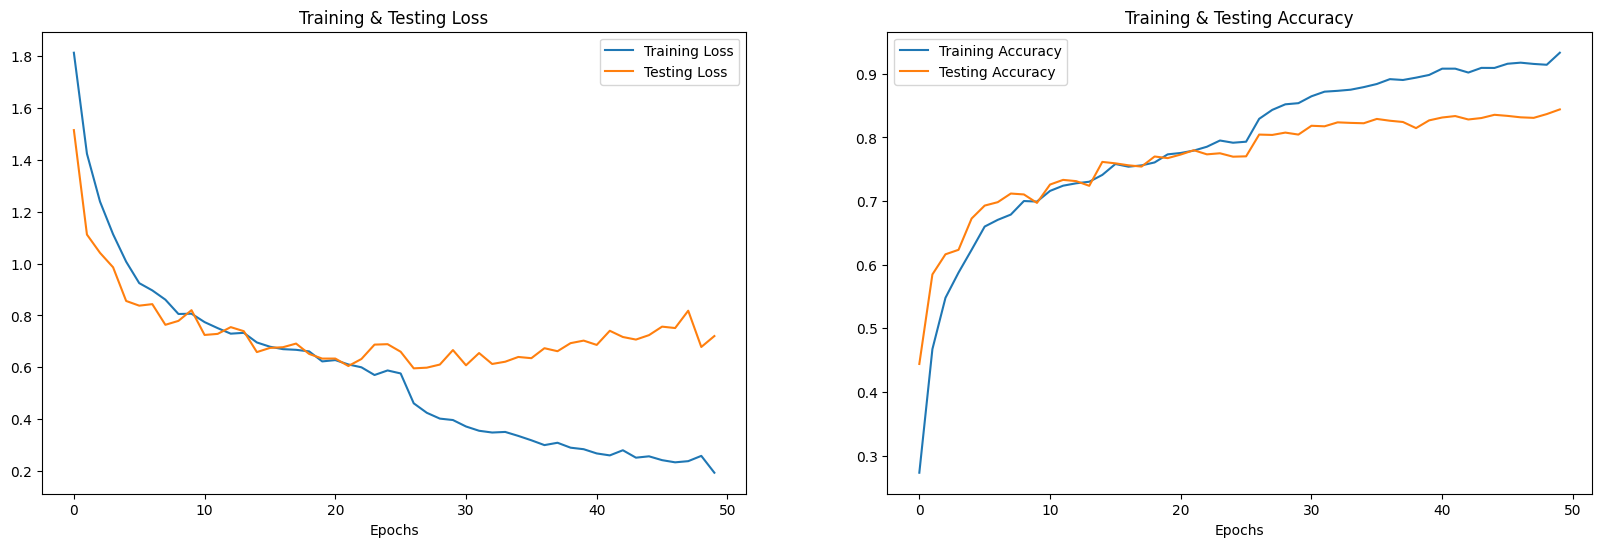

In [23]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [24]:
x_test


array([[[ 0.62512659],
        [ 0.49117412],
        [ 0.41824305],
        ...,
        [-0.19056407],
        [-0.17239721],
        [-0.17000001]],

       [[-1.35801822],
        [ 0.66110742],
        [ 1.21547733],
        ...,
        [-0.20276626],
        [-0.1838663 ],
        [-0.18125144]],

       [[-1.25367377],
        [-0.89850896],
        [-0.56492107],
        ...,
        [-0.19558755],
        [-0.18347219],
        [-0.18124821]],

       ...,

       [[ 0.11057038],
        [ 0.90633061],
        [-1.00431444],
        ...,
        [-0.20258474],
        [-0.18384749],
        [-0.18124767]],

       [[ 0.79814602],
        [-0.87982465],
        [ 0.39869915],
        ...,
        [-0.0978391 ],
        [-0.08129568],
        [-0.07657824]],

       [[ 1.31735037],
        [-1.05537968],
        [ 0.03448163],
        ...,
        [ 0.08800896],
        [ 0.04581022],
        [ 0.05461515]]])

In [25]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

111/111 [==============================] - 3s 28ms/step


In [26]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,sad,sad
2,surprise,surprise
3,disgust,disgust
4,happy,happy
5,neutral,neutral
6,disgust,neutral
7,fear,fear
8,disgust,fear
9,angry,angry


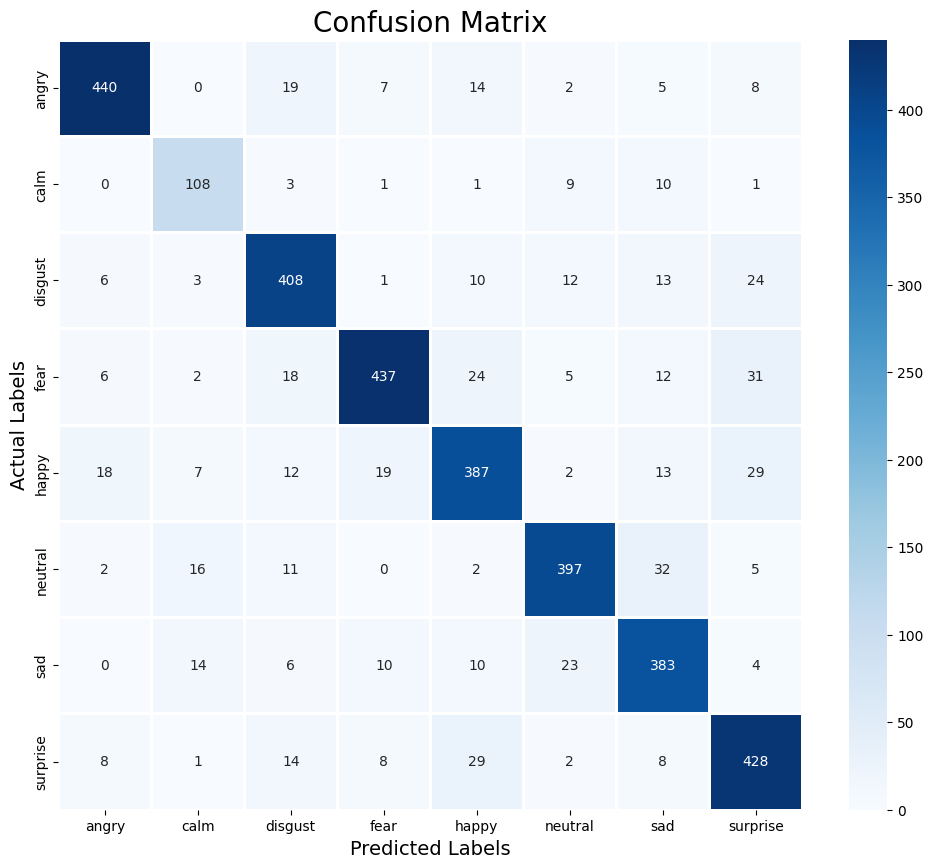

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.89      0.90       495
        calm       0.72      0.81      0.76       133
     disgust       0.83      0.86      0.84       477
        fear       0.90      0.82      0.86       535
       happy       0.81      0.79      0.80       487
     neutral       0.88      0.85      0.87       465
         sad       0.80      0.85      0.83       450
    surprise       0.81      0.86      0.83       498

    accuracy                           0.84      3540
   macro avg       0.83      0.84      0.84      3540
weighted avg       0.85      0.84      0.84      3540

